In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.backends.mps as mps 
import copy
import time
import matplotlib.pyplot as plt

# Configuration

In [32]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

print("Running on device %s" % device)

Running on device mps


In [33]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load Datasets

In [34]:
batch_size = 64
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)


# Simple CNN model

In [35]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [36]:
def measure_gradient_size(model):
    total_size = 0
    for param in model.parameters():
        if param.grad is not None:
            total_size += param.grad.numel() * param.grad.element_size()
    return total_size / (1024 * 1024)  # Convert to MB


# AGC Function

In [37]:
def apply_agc(model, threshold=1e-3):
    total_agc_size = 0
    for param in model.parameters():
        if param.grad is not None:
            grad = param.grad
            mask = torch.abs(grad) > threshold
            param.grad *= mask
            total_agc_size += mask.sum().item() * param.grad.element_size()
    return total_agc_size / (1024 * 1024)


# Training function

In [ ]:
def train_model(model, use_lusgd=False, use_agc=False, K=5, threshold=1e-3, epochs=3):
    model = copy.deepcopy(model).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_history = []
    comm_cost_history = []
    
    for epoch in range(epochs):
        running_loss = 0.0
        comm_cost = 0.0
        local_model = copy.deepcopy(model.state_dict()) if use_lusgd else None
        
        for i, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            
            if use_agc:
                comm_cost += apply_agc(model, threshold)
            else:
                comm_cost += measure_gradient_size(model)
            
            optimizer.step()
            running_loss += loss.item()
            
            if use_lusgd and (i + 1) % K == 0:
                with torch.no_grad():
                    global_state_dict = model.state_dict()
                    for key in global_state_dict:
                        global_state_dict[key] = (global_state_dict[key] + local_model[key]) / 2
                    model.load_state_dict(global_state_dict)
                local_model = copy.deepcopy(model.state_dict())
        
        avg_loss = running_loss / len(trainloader)
        loss_history.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
    
    return model, loss_history, comm_cost_history

# Train Model

In [39]:
print("Training Baseline Model")
baseline_model, baseline_loss, baseline_comm = train_model(CNN(), use_lusgd=False, use_agc=False)


Training Baseline Model
Epoch 1/3, Loss: 1.4283, Comm Cost: 6542.60 MB
Epoch 2/3, Loss: 1.0174, Comm Cost: 6542.60 MB
Epoch 3/3, Loss: 0.8427, Comm Cost: 6542.60 MB


In [40]:
print("Training Model with AGC")
agc_model, agc_loss, agc_comm = train_model(CNN(), use_lusgd=False, use_agc=True)


Training Model with AGC
Epoch 1/3, Loss: 1.5705, Comm Cost: 226.80 MB
Epoch 2/3, Loss: 1.2073, Comm Cost: 219.10 MB
Epoch 3/3, Loss: 1.0440, Comm Cost: 208.30 MB


In [41]:
print("Training Model with LU-SGD")
lusgd_model, lusgd_loss, lusgd_comm = train_model(CNN(), use_lusgd=True, use_agc=False)


Training Model with LU-SGD
Epoch 1/3, Loss: 1.4554, Comm Cost: 6542.60 MB
Epoch 2/3, Loss: 1.0606, Comm Cost: 6542.60 MB
Epoch 3/3, Loss: 0.8955, Comm Cost: 6542.60 MB


# Plot Loss Comparison

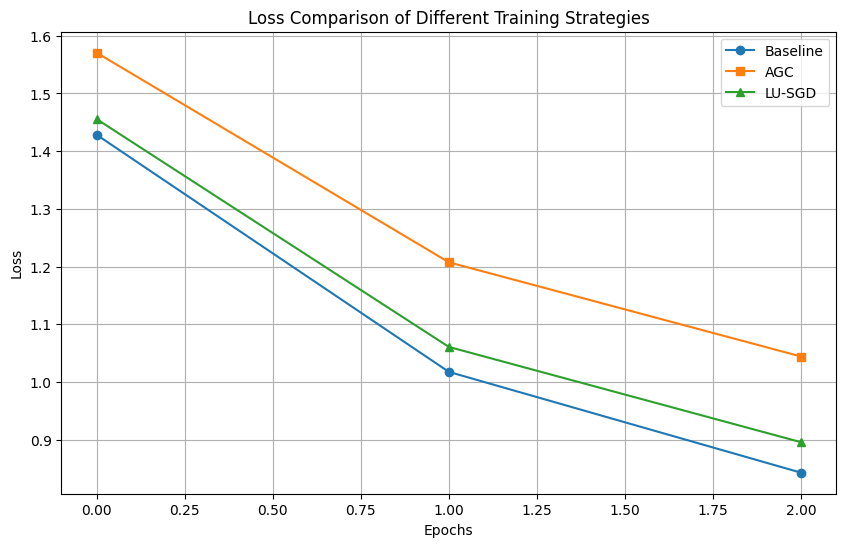

In [42]:
plt.figure(figsize=(10, 6))
plt.plot(baseline_loss, label="Baseline", marker='o')
plt.plot(agc_loss, label="AGC", marker='s')
plt.plot(lusgd_loss, label="LU-SGD", marker='^')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Comparison of Different Training Strategies")
plt.legend()
plt.grid()
plt.show()